In [1]:
from pycalphad import Database, Model, calculate, equilibrium, variables as v
from xarray import DataArray

In [2]:
class PrecipitateModel(Model):
    matrix_chempots = []
    @property
    def matrix_hyperplane(self):
        return sum(self.moles(self.nonvacant_elements[i])*self.matrix_chempots[i]
                   for i in range(len(self.nonvacant_elements)))
    @property
    def GM(self):
        return self.ast - self.matrix_hyperplane

class GibbsThompsonModel(Model):
    "Spherical particle."
    radius = 1e-6 # m
    volume = 7.3e-6 # m^3/mol
    interfacial_energy = 250e-3 # J/m^2
    elastic_misfit_energy = 0 # J/mol
    @property
    def GM(self):
        return self.ast + (2*self.interfacial_energy/self.radius + self.elastic_misfit_energy) * self.volume

In [3]:
import numpy as np

def parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp):
    conds = {v.N: 1, v.P: 1e5, v.T: temp}
    conds.update(matrix_comp)
    matrix_eq = equilibrium(dbf, comps, matrix_phase, conds)
    # pycalphad currently doesn't have a way to turn global minimization off and directly specify starting points
    if matrix_eq.isel(vertex=1).Phase.values.flatten() != ['']:
        raise ValueError('Matrix phase has miscibility gap. This bug will be fixed in the future')
    matrix_chempots = matrix_eq.MU.values.flatten()
    # This part will not work until mass balance constraint can be relaxed
    #precip = PrecipitateModel(dbf, comps, precipitate_phase)
    #precip.matrix_chempots = matrix_chempots
    #conds = {v.N: 1, v.P: 1e5, v.T: temp}
    #df_eq = equilibrium(dbf, comps, precipitate_phase, conds, model=precip)
    df_eq = calculate(dbf, comps, precipitate_phase, T=temp, N=1, P=1e5)
    df_eq['GM'] = df_eq.X.values[0,0,0].dot(matrix_chempots) - df_eq.GM
    selected_idx = df_eq.GM.argmax()
    return matrix_eq.isel(vertex=0), df_eq.isel(points=selected_idx)

def nucleation_barrier(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp,
                       interfacial_energy, precipitate_volume):
    "Spherical precipitate."
    matrix_eq, precip_eq = parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp)
    precip_driving_force = float(precip_eq.GM.values) # J/mol
    elastic_misfit_energy = 0 # J/m^3
    barrier = 16./3 * np.pi * interfacial_energy **3 / (precip_driving_force + elastic_misfit_energy) ** 2 # J/mol
    critical_radius = 2 * interfacial_energy / ((precip_driving_force / precipitate_volume) + elastic_misfit_energy) # m
    print(temp, critical_radius)
    if critical_radius < 0:
        barrier = np.inf
    cluster_area = 4*np.pi*critical_radius**2
    cluster_volume = (4./3) * np.pi * critical_radius**3
    return barrier, precip_driving_force, cluster_area, cluster_volume, matrix_eq, precip_eq

def growth_rate(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp, particle_radius):
    conds = {v.N: 1, v.P: 1e5, v.T: temp}
    conds.update(matrix_comp)
    # Fictive; Could retrieve from TDB in principle
    mobility = 1e-7 * np.exp(-14e4/(8.3145*temp)) # m^2 / s
    mobilities = np.eye(len(matrix_comp)+1) * mobility

    matrix_ff_eq, precip_eq = parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp)
    precip_driving_force = float(precip_eq.GM.values) # J/mol
    interfacial_energy = 250e-3 # J/m^2
    precipitate_volume = 7.3e-6 # m^3/mol
    elastic_misfit_energy = 0 # J/m^3
    # Spherical particle
    critical_radius = 2 * interfacial_energy / ((precip_driving_force / precipitate_volume) + elastic_misfit_energy) # m
    # XXX: Should really be done with global min off, fixed-phase conditions, etc.
    # As written, this will break with miscibility gaps
    particle_mod = GibbsThompsonModel(dbf, comps, precipitate_phase)
    particle_mod.radius = particle_radius
    interface_eq = equilibrium(dbf, comps, [matrix_phase, precipitate_phase], conds,
                               model={precipitate_phase: particle_mod})
    matrix_idx = np.nonzero((interface_eq.Phase==matrix_phase).values.flatten())[0]
    if len(matrix_idx) > 1:
        raise ValueError('Matrix phase has miscibility gap')
    elif len(matrix_idx) == 0:
        # Matrix is metastable at this composition; massive transformation kinetics?
        print(interface_eq)
        raise ValueError('Matrix phase is not stable')
    else:
        matrix_idx = matrix_idx[0]
        matrix_interface_eq = interface_eq.isel(vertex=matrix_idx)

    precip_idx = np.nonzero((interface_eq.Phase==precipitate_phase).values.flatten())[0]
    if len(precip_idx) > 1:
        raise ValueError('Precipitate phase has miscibility gap')
    elif len(precip_idx) == 0:
        precip_conc = np.zeros(len(interface_eq.component))
        # Precipitate is metastable at this radius (it will start to dissolve)
        # Compute equilibrium for precipitate by itself at parallel tangent composition
        pt_comp = {v.X(str(comp)): precip_eq.X.values.flatten()[idx] for idx, comp in enumerate(precip_eq.component.values[:-1])}
        conds = {v.N: 1, v.P: 1e5, v.T: temp}
        conds.update(pt_comp)
        precip_interface_eq = equilibrium(dbf, comps, precipitate_phase, conds,
                               model={precipitate_phase: particle_mod})
        precip_interface_eq = precip_interface_eq.isel(vertex=0)
    else:
        precip_idx = precip_idx[0]
        precip_interface_eq = interface_eq.isel(vertex=precip_idx)
    
    eta_geo_factor = 1.0
    # Growth equation from Eq. 12, M. Paliwal and I.-H Jung, Calphad, 2019
    velocity = 2*interfacial_energy * precipitate_volume * (1./critical_radius - 1./particle_radius)
    x_int_precip = precip_interface_eq.X.values.flatten()
    x_int_matrix = matrix_interface_eq.X.values.flatten()
    denominator = 0
    for i in range(mobilities.shape[0]-1):
        for j in range(mobilities.shape[1]-1):
            denominator += (x_int_precip[i] - x_int_matrix[i]) * (x_int_precip[j] - x_int_matrix[j]) / mobilities[i,j]
    velocity /= denominator
    return velocity



In [21]:
dbf = Database('Al-Cu-Zr_Zhou.tdb')
comps = ['AL', 'CU', 'VA']

matrix_compositions = np.linspace(1e-4, 1-1e-4, num=30)
particle_radii = np.logspace(-10, -3, num=60)

velocities = np.zeros((matrix_compositions.shape[0], particle_radii.shape[0]))

for mc_idx in range(velocities.shape[0]):
    matrix_comp = {v.X('CU'): matrix_compositions[mc_idx]}
    for r_idx in range(velocities.shape[1]):
        print(mc_idx, r_idx)
        velocities[mc_idx, r_idx] = growth_rate(dbf, comps, 'BCC_A2', matrix_comp, 'ETA2', 800, particle_radii[r_idx])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27


25 9
25 10
25 11
25 12
25 13
25 14
25 15
25 16
25 17
25 18
25 19
25 20
25 21
25 22
25 23
25 24
25 25
25 26
25 27
25 28
25 29
25 30
25 31
25 32
25 33
25 34
25 35
25 36
25 37
25 38
25 39
25 40
25 41
25 42
25 43
25 44
25 45
25 46
25 47
25 48
25 49
25 50
25 51
25 52
25 53
25 54
25 55
25 56
25 57
25 58
25 59
26 0
26 1
26 2
26 3
26 4
26 5
26 6
26 7
26 8
26 9
26 10
26 11
26 12
26 13
26 14
26 15
26 16
26 17
26 18
26 19
26 20
26 21
26 22
26 23
26 24
26 25
26 26
26 27
26 28
26 29
26 30
26 31
26 32
26 33
26 34
26 35
26 36
26 37
26 38
26 39
26 40
26 41
26 42
26 43
26 44
26 45
26 46
26 47
26 48
26 49
26 50
26 51
26 52
26 53
26 54
26 55
26 56
26 57
26 58
26 59
27 0
27 1
27 2
27 3
27 4
27 5
27 6
27 7
27 8
27 9
27 10
27 11
27 12
27 13
27 14
27 15
27 16
27 17
27 18
27 19
27 20
27 21
27 22
27 23
27 24
27 25
27 26
27 27
27 28
27 29
27 30
27 31
27 32
27 33
27 34
27 35
27 36
27 37
27 38
27 39
27 40
27 41
27 42
27 43
27 44
27 45
27 46
27 47
27 48
27 49
27 50
27 51
27 52
27 53
27 54
27 55
27 56
27 57
27 58
2

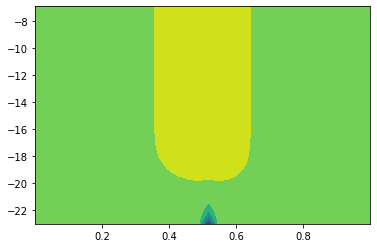

In [24]:
from pycalphad import calculate
import matplotlib.pyplot as plt
X, Y = np.meshgrid(matrix_compositions, np.log(particle_radii))
plt.contourf(X, Y, velocities.T, levels=5)

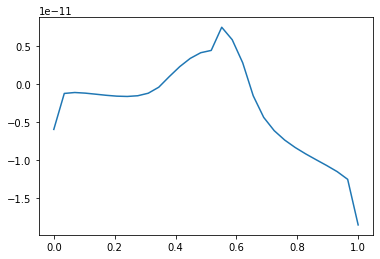

In [43]:
import matplotlib.pyplot as plt

plt.plot(matrix_compositions, velocities[:,55])